In [4]:
# initial set-up
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sewar.full_ref import rmse, uqi
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

torch.manual_seed(0)
np.random.seed(0)

c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
#  CONFIGURATIONS - HYPER PARAMETERS
################################################################
#  configurations - HYPER PARAMETERS
################################################################
epochs = 20
batch_size = 10
learning_rate = 0.001
step_size = 50
gamma = 0.5

weight_decay=1e-4

width = 400
output_file_name = 'output_fcn_100.txt'
# Hyperparameters to change - epoch{10,100,200}, step_size{}, batchsize{}, gamma{}, modes{}, weight_decay{}

In [13]:
class FCN_sigma(nn.Module):
    def __init__(self):
        super(FCN_sigma, self).__init__()
       
        self.fc0 = nn.Linear(64, 500)
        self.fc1 = nn.Linear(500, 500)
        self.fc2 = nn.Linear(500, 256)

    def forward(self, x):
       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)        
        x = F.sigmoid(x)
        return x





#########################################################
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc0 = nn.Linear(64, 256)
        
    def forward(self, x):       
        x = self.fc0(x)
        x = F.sigmoid(x)
        return x


############################################################
class FCN2(nn.Module):
    def __init__(self):
        super(FCN2, self).__init__()
       
        self.fc0 = nn.Linear(64, 400)
        self.fc1 = nn.Linear(400, 256)

    def forward(self, x):       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.sigmoid(x)
        return x


##########################################################
class FCN3(nn.Module):
    def __init__(self):
        super(FCN3, self).__init__()
       
        self.fc0 = nn.Linear(64, 400)
        self.fc1 = nn.Linear(400, 400)
        self.fc2 = nn.Linear(400, 256)

    def forward(self, x):
       
        x = self.fc0(x)
        x = F.relu(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.sigmoid(x)
        return x

In [7]:
# DATA LOADING
############################## DATA LOADING ########################################
raw_data = scipy.io.loadmat('./datasets/complete_data')

sol = np.asarray(raw_data['solution_data'])
mes = np.asarray(raw_data['measurement_data'])


def convert_data(data_x, data_y):
    data_X = torch.from_numpy(data_x).float()
    data_Y = torch.from_numpy(data_y).float()
    return data_X, data_Y

# we are solving the inverse problem, so going from measurements, to solutions
X, y = convert_data(mes, sol)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_normalizer = UnitGaussianNormalizer(y_train)
#y_train = y_normalizer.encode(y_train)

#x_normalizer = UnitGaussianNormalizer(X_train)
#X_train = x_normalizer.encode(X_train)
#X_test = x_normalizer.encode(X_test)


#batch_size = 10
#train_loader = DataLoader(data_utils.TensorDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
train_dataset = TensorDataset( X_train, y_train )
test_dataset = TensorDataset( X_test, y_test )

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ntrain = X_train.shape[0]
ntest = X_test.shape[0]

print('training: measurement', X_train.shape, 'solution', y_train.shape)
print('test: measurement', X_test.shape, 'solution', y_test.shape)

training: measurement torch.Size([8000, 64]) solution torch.Size([8000, 256])
test: measurement torch.Size([2000, 64]) solution torch.Size([2000, 256])


In [8]:
# MODEL METRICS
###################################
# MODEL METRICS
###################################
def model_metrics(model,test_loader,ntrain):
    rms_values, psnr_values, ssim_values, uqi_values = [], [], [], []

    for test_num in range(ntest):
        K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
        model.eval()

        predicted_np = np.reshape(model(K).detach().cpu().numpy(),(16,16))

        truth = test_loader.dataset[test_num][1]
        truth_np = np.reshape(truth.numpy(),(16,16))

        #diff_image = predicted - truth_np
        #np.sqrt(np.sum(diff_image**2)/256)

        rms_values.append(rmse(predicted_np, truth_np))
        psnr_values.append(psnr(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        ssim_values.append(ssim(truth_np, predicted_np, data_range=predicted_np.max() - predicted_np.min()))
        uqi_values.append(uqi(predicted_np, truth_np))

    model_rms = sum(rms_values)/ len(rms_values)
    std_rms = np.std(np.array(rms_values))

    model_psnr = sum(psnr_values)/ len(psnr_values)
    std_psnr = np.std(np.array(psnr_values))

    model_ssim = sum(ssim_values)/ len(ssim_values)
    std_ssim = np.std(np.array(ssim_values))

    model_uqi = sum(uqi_values)/ len(uqi_values)
    std_uqi = np.std(np.array(uqi_values))


    print("RMSE: ", round(model_rms,5), round(std_rms,5), sep="---")
    print("PSNR: ", round(model_psnr,5), round(std_psnr,5), sep="---")
    print("SSIM: ", round(model_ssim,5), round(std_ssim,5), sep="---")
    #print("UQI: ", model_uqi, std_uqi, sep="---")


    output = {
    "rms": rms_values,
    "psnr": psnr_values,
    "ssim": ssim_values,
    "uqi": uqi_values,
    # average values
    'model_rms': [round(model_rms,5),round(std_rms,5)],
    'model_psnr': [round(model_psnr,5),round(std_psnr,5)],
    'model_ssim': [round(model_ssim,5),round(std_ssim,5)]
    }
    return output 

In [9]:
# TRAINING AND EVALUATION
################################################################
# TRAINING AND EVALUATION
################################################################


def train_model(model, epochs, batch_size, learning_rate, weight_decay, step_size, gamma):
    optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses, test_losses, epoch_time = [], [], []

    myloss = LpLoss(size_average=False)
    for ep in range(epochs):
        model.train()
        t1 = default_timer()
        train_mse = 0
        train_l2 = 0
        total_time = 0
        for x, y in train_loader:
            x, y = x.cuda(), y.cuda()

            optimizer.zero_grad()
            #print('in: ',x.shape)
            out = model(x)
            #print('out: ',out.shape)

            mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
            l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
            l2.backward() # use the l2 relative loss

            optimizer.step()
            train_mse += mse.item()
            train_l2 += l2.item()

        scheduler.step()
        model.eval()
        test_l2 = 0.0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.cuda(), y.cuda()

                out = model(x)
                test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        #train_mse /= len(train_loader)
        train_l2 /= ntrain
        train_losses.append(train_l2)
        test_l2 /= ntest
        test_losses.append(test_l2)


        t2 = default_timer()
        epoch_time.append(t2 - t1)

        print(ep, t2 - t1, train_l2, test_l2)
    total_time = sum(epoch_time)
    print("TOTAL TIME: ", round(total_time,2), sep="---")

    output = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "epoch_time": epoch_time,
    "training_time": total_time,
    "model": model
    }
    return output 

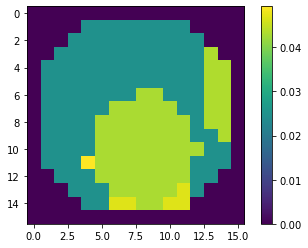

In [10]:
#Actual
test_num = 434
truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [8]:
test_loader.dataset[test_num][0].shape 

torch.Size([64])

In [9]:

with open(output_file_name, 'w') as output:
    output.write('textbf{No of Layers} & textbf{Width} & textbf{No of Parameters} & textbf{Training Time /sec} & textbf{RMSE} & textbf{PSNR} & textbf{SSIM} \n')


In [10]:
''' 
# ONE LAYER
############################################################################

model_fcn1 = FCN().cuda()
no_param1 = count_params(model_fcn1)
print(no_param1)
output1 = train_model(model_fcn1, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
timeL1  = round(output1.get('training_time'),2)


output1_model = output1.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
resultsL1 = model_metrics(output1_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output1_model.eval()
predicted = np.reshape(output1_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()
'''

' \n# ONE LAYER\n############################################################################\n\nmodel_fcn1 = FCN().cuda()\nno_param1 = count_params(model_fcn1)\nprint(no_param1)\noutput1 = train_model(model_fcn1, 20, batch_size, learning_rate, weight_decay, step_size, gamma)\ntimeL1  = round(output1.get(\'training_time\'),2)\n\n\noutput1_model = output1.get("model")\n#torch.save(output_1L_model, \'fno2D_1l.h5\')\nresultsL1 = model_metrics(output1_model,test_loader,ntrain)\n\n# TEST NETWORK RESULTS\n############################################################################\nK = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()\noutput1_model.eval()\npredicted = np.reshape(output1_model(K).detach().cpu().numpy(),(16,16))\nplt.imshow(predicted)\nplt.colorbar()\n'

In [11]:
''' 
# Open a file with access mode 'a'
file_object = open('output.txt', 'a')
# Append 'hello' at the end of file
info1 = '1 & ' + 'none*' + ' & ' + str(no_param1) + ' & ' + str(timeL1) + ' & '
info2 = str(resultsL1.get('model_rms')[0]) + ' \ textpm ' + str(resultsL1.get('model_rms')[1]) + '  &  ' + str(resultsL1.get('model_psnr')[0]) + ' \ textpm ' + str(resultsL1.get('model_psnr')[1]) + '  &  ' + str(resultsL1.get('model_ssim')[0]) + ' \ textpm ' + str(resultsL1.get('model_ssim')[1]) + '\n'
file_object.write(info1 + info2)

# Close the file
file_object.close()

'''

" \n# Open a file with access mode 'a'\nfile_object = open('output.txt', 'a')\n# Append 'hello' at the end of file\ninfo1 = '1 & ' + 'none*' + ' & ' + str(no_param1) + ' & ' + str(timeL1) + ' & '\ninfo2 = str(resultsL1.get('model_rms')[0]) + ' \\ textpm ' + str(resultsL1.get('model_rms')[1]) + '  &  ' + str(resultsL1.get('model_psnr')[0]) + ' \\ textpm ' + str(resultsL1.get('model_psnr')[1]) + '  &  ' + str(resultsL1.get('model_ssim')[0]) + ' \\ textpm ' + str(resultsL1.get('model_ssim')[1]) + '\n'\nfile_object.write(info1 + info2)\n\n# Close the file\nfile_object.close()\n\n"

128656


c:\Users\azhir\anaconda3\envs\gundam\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 3.197155199944973 0.9119410774111748 0.7521727843284607
1 1.6431064999196678 0.575157448232174 0.296885752081871
2 1.5764730999944732 0.2242545426338911 0.18706919527053834
3 1.6207447999622673 0.16769941971451044 0.1536287080645561
4 1.6829776000231504 0.1576163707524538 0.13855916517972947
5 1.591161899967119 0.14765839265286923 0.13531669068336488
6 1.5701330000301823 0.14247638905793428 0.18413459461927414
7 1.5962349999463186 0.14197741666436195 0.14153910583257676
8 1.5230751000344753 0.13944823931157588 0.1350480511188507
9 1.584695199970156 0.13691485399752856 0.1592027051448822
10 1.6564148999750614 0.13707302509248256 0.15944594019651412
11 1.5336395999183878 0.13429278789460658 0.1306845116019249
12 1.5617027999833226 0.1340274101793766 0.1461604592204094
13 1.5753542000893503 0.132887466609478 0.13465478706359862
14 1.6040580000262707 0.13206025048345327 0.13380742114782335
15 1.428711700020358 0.1318327595293522 0.12624918386340142
16 1.6081125000491738 0.130779365785419

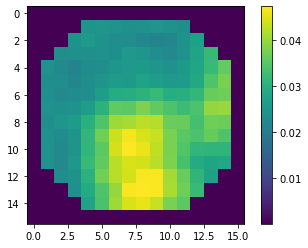

In [11]:
# TWO LAYER
############################################################################
model_fcn2 = FCN2().cuda()
no_param2 = count_params(model_fcn2)
print(no_param2)
output2 = train_model(model_fcn2, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
output2_model = output2.get("model")


timeL2  = round(output2.get('training_time'),2)
resultsL2 = model_metrics(output2_model,test_loader,ntrain)


#torch.save(output_1L_model, 'fno2D_1l.h5')

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output2_model.eval()
predicted = np.reshape(output2_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [12]:
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info1 = '2 & ' + str(width) + ' & ' + str(no_param2) + ' & ' + str(timeL2) + ' & '
info2 = str(resultsL2.get('model_rms')[0]) + ' \ textpm ' + str(resultsL2.get('model_rms')[1]) + '  &  ' + str(resultsL2.get('model_psnr')[0]) + ' \ textpm ' + str(resultsL2.get('model_psnr')[1]) + '  &  ' + str(resultsL2.get('model_ssim')[0]) + ' \ textpm ' + str(resultsL2.get('model_ssim')[1]) + '\n'
file_object.write(info1 + info2)

# Close the file
file_object.close()

289056
0 2.2135635999729857 0.939951595723629 0.49452982091903686
1 2.0449315999867395 0.282130237787962 0.21305916839838027
2 2.0410994000267237 0.20313525448739528 0.1775503379702568
3 2.085913799935952 0.1786620838344097 0.1601683583855629
4 2.01488979998976 0.16419396424293517 0.1491869422197342
5 2.131561900023371 0.15682946875691414 0.14852228730916978
6 2.0743433999596164 0.15018903087824584 0.14965168815851213
7 2.0270866999635473 0.14708281724154948 0.14080936497449875
8 2.062727899989113 0.14559601406008005 0.13945918619632722
9 2.040704199927859 0.1423572358340025 0.15912907946109772
10 2.046419500024058 0.14211763389408588 0.13027481922507286
11 1.9834735000040382 0.1391742772012949 0.13581470876932145
12 2.0307451999979094 0.13770953357964755 0.14209034216403962
13 2.045580300036818 0.13662788850814103 0.14564795672893524
14 2.0786774998996407 0.13727646717429162 0.14688783699274063
15 2.05497979989741 0.13373088172823192 0.12841226172447204
16 2.023143899976276 0.13317721

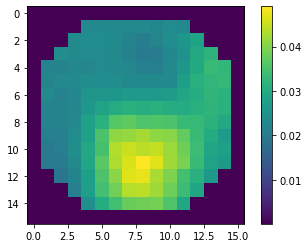

In [14]:
# THREE LAYER
############################################################################

model_fcn3 = FCN3().cuda()
no_param3 = count_params(model_fcn3)
print(no_param3)

output3 = train_model(model_fcn3, 20, batch_size, learning_rate, weight_decay, step_size, gamma)
timeL3  = round(output3.get('training_time'),2)

output3_model = output3.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
resultsL3 = model_metrics(output3_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output3_model.eval()
predicted = np.reshape(output3_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [15]:
# Open a file with access mode 'a'
file_object = open(output_file_name, 'a')
# Append 'hello' at the end of file
info1 = '3 & ' + str(width) + ' & ' + str(no_param3) + ' & ' + str(timeL3) + ' & '
info2 = str(resultsL3.get('model_rms')[0]) + ' \ textpm ' + str(resultsL3.get('model_rms')[1]) + '  &  ' + str(resultsL3.get('model_psnr')[0]) + ' \ textpm ' + str(resultsL3.get('model_psnr')[1]) + '  &  ' + str(resultsL3.get('model_ssim')[0]) + ' \ textpm ' + str(resultsL3.get('model_ssim')[1]) + '\n'
file_object.write(info1 + info2)

# Close the file
file_object.close()

# OTHER STUFF

In [16]:
# Inference test
import timeit

start = timeit.default_timer()
for test_num in range(2000):
    K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
    output_sigma_model.eval()
    predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
    
stop = timeit.default_timer()
print('Time: ', stop - start) 


NameError: name 'output_sigma_model' is not defined

In [ ]:
'''
3 LAYERS, 100 between layers 
TOTAL TIME: ---41.235324100009166
RMSE: ---0.0036905181528051408---0.0016030583832068695 \n
PSNR: ---22.192018796148748---2.4898589131934084 \n
SSIM: ---0.8061080868645687---0.04830101196953558 \n
UQI: ---0.9881714888559991---0.00820526242779294 \n

2 Layers, 300 between layers
TOTAL TIME: ---31.88879379998616
RMSE: ---0.003442944375075244---0.0014584607390701226
PSNR: ---23.53519948358796---2.3388028309876634
SSIM: ---0.8161173935399294---0.04641244210837502
UQI: ---0.9909905319520759---0.005908317355641168
'''

In [ ]:
# No Activation - TEST NETWORK
############################################################################

model_fcn_sigma = FCN_lin().cuda()
print(count_params(model_fcn_sigma))
output_sigma = train_model(model_fcn_sigma, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_sigma_model = output_sigma.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_linear = model_metrics(output_sigma_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_sigma_model.eval()
predicted = np.reshape(output_sigma_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [ ]:

# SOFTMAX - TEST NETWORK
############################################################################

model_softmax = FCN_softmax().cuda()
print(count_params(model_softmax))
output_softmax = train_model(model_softmax, 20, batch_size, learning_rate, weight_decay, step_size, gamma)

output_softmax_model = output_softmax.get("model")
#torch.save(output_1L_model, 'fno2D_1l.h5')
results_softmax = model_metrics(output_softmax_model,test_loader,ntrain)

# TEST NETWORK RESULTS
############################################################################
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
output_softmax_model.eval()
predicted = np.reshape(output_softmax_model(K).detach().cpu().numpy(),(16,16))
plt.imshow(predicted)
plt.colorbar()

In [ ]:
#plt.plot(output_1L.get('train_losses')[5:20], label='1 fourier layer')
plt.plot(range(5,20),output_1L.get('train_losses')[5:20], label='2 fourier layers')
#plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend(frameon=False)

# Analysing performance

In [ ]:
# Models
#############################################################################
model = model_fcn_sigma
results =  results_sigma


In [ ]:
metric_type = 'ssim'         # can be the following rms, ssim, psnr

fig1, ax1 = plt.subplots()
red_cross = dict(markerfacecolor='r', marker='x')
data = (results.get(metric_type))

ax1.boxplot(data, vert=False, flierprops=red_cross)
plt.xlabel(metric_type)
plt.show

In [ ]:
# Create outlier range
q75, q25 = np.percentile(data, [75 ,25])
iqr = q75 - q25
outliers = [q25-1.5*iqr,q75+1.5*iqr]

# zip data
data_no = range(len(data))
listed_data = zip(data_no,data)

data_list = list(listed_data)



print('outliers are anything below ',outliers[0],' or above ',outliers[1])

outlier_list = []
for i in range(len(data)):
    if data_list[i][1] < outliers[0]:
        outlier_list.append(data_list[i])
    elif data_list[i][1] > outliers[1]:
        outlier_list.append(data_list[i])


In [ ]:
print('the number of outliers are ',len(outlier_list) )
#worst reconstruction
worst = [np.min(np.asarray(outlier_list)[:,1]), np.max(np.asarray(outlier_list)[:,1]) ]
print('for outliers, the lowest metric value is ',worst[0],' and highest is', worst[1])

# The values for the worst performers! 
for i in range(len(outlier_list)):
    if outlier_list[i][1] ==  worst[0]:
        print(outlier_list[i])
    elif outlier_list[i][1] == worst[1]:
        print(outlier_list[i])


In [ ]:
print(outlier_list)

In [ ]:
#Actual
test_num = 1784

truth_out = test_loader.dataset[test_num][1]
plt.imshow(np.reshape(truth_out.numpy(),(16,16)))
plt.colorbar()

In [ ]:
# Quickly showing that our model gives expected results. 
model.eval()
K = torch.unsqueeze(test_loader.dataset[test_num][0], 0).cuda()
predicted = np.reshape(model(K).detach().cpu().numpy(),(16,16))

plt.imshow(predicted)
plt.colorbar()

# Testing Stuff